<a href="https://colab.research.google.com/github/pinilDissanayaka/Paddy-Doctor-Paddy-Disease-Classification/blob/main/DenseNet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install livelossplot
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 2.9 MB/s eta 0:00:00


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download ricardosalvatorelli1/paddydoctor

Dataset URL: https://www.kaggle.com/datasets/ricardosalvatorelli1/paddydoctor
License(s): unknown
 98% 0.99G/1.02G [00:15<00:00, 73.9MB/s]
100% 1.02G/1.02G [00:15<00:00, 69.9MB/s]


In [ ]:
! unzip paddydoctor.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/downy_mildew/100992.jpg  
  inflating: train_images/downy_mildew/100995.jpg  
  inflating: train_images/downy_mildew/101015.jpg  
  inflating: train_images/downy_mildew/101020.jpg  
  inflating: train_images/downy_mildew/101022.jpg  
  inflating: train_images/downy_mildew/101024.jpg  
  inflating: train_images/downy_mildew/101034.jpg  
  inflating: train_images/downy_mildew/101050.jpg  
  inflating: train_images/downy_mildew/101078.jpg  
  inflating: train_images/downy_mildew/101096.jpg  
  inflating: train_images/downy_mildew/101103.jpg  
  inflating: train_images/downy_mildew/101114.jpg  
  inflating: train_images/downy_mildew/101119.jpg  
  inflating: train_images/downy_mildew/101142.jpg  
  inflating: train_images/downy_mildew/101177.jpg  
  inflating: train_images/downy_mildew/101178.jpg  
  inflating: train_images/downy_mildew/101181.jpg  
  inflating: train_images/downy_mildew/101205.jpg  
  inflating: 

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 as cv
import os
import random
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAvgPool2D, Activation
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKerasTF
import visualkeras
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings(action = 'ignore')

In [ ]:
trainDir=f"/content/train_images"
testDir=f"/content/test_images"

print(f"Training directory : {trainDir}")
print(f"Testing directory : {testDir} \n")

Training directory : /content/train_images
Testing directory : /content/test_images 



In [ ]:
trainFolders=glob(os.path.join(trainDir, '*'))
outputSize=len(trainFolders)

trainImageCount={}

print(f'Number of folders: {outputSize}\n')
for folder in trainFolders:
  trainImageCount[os.path.basename(folder)]=len(glob(os.path.join(folder, '*')))
  print(f"class {os.path.basename(folder)}: {len(glob(os.path.join(folder, '*')))}")

Number of folders: 10

class blast: 1738
class brown_spot: 965
class downy_mildew: 620
class bacterial_panicle_blight: 337
class bacterial_leaf_streak: 380
class dead_heart: 1442
class bacterial_leaf_blight: 479
class hispa: 1594
class tungro: 1088
class normal: 1764


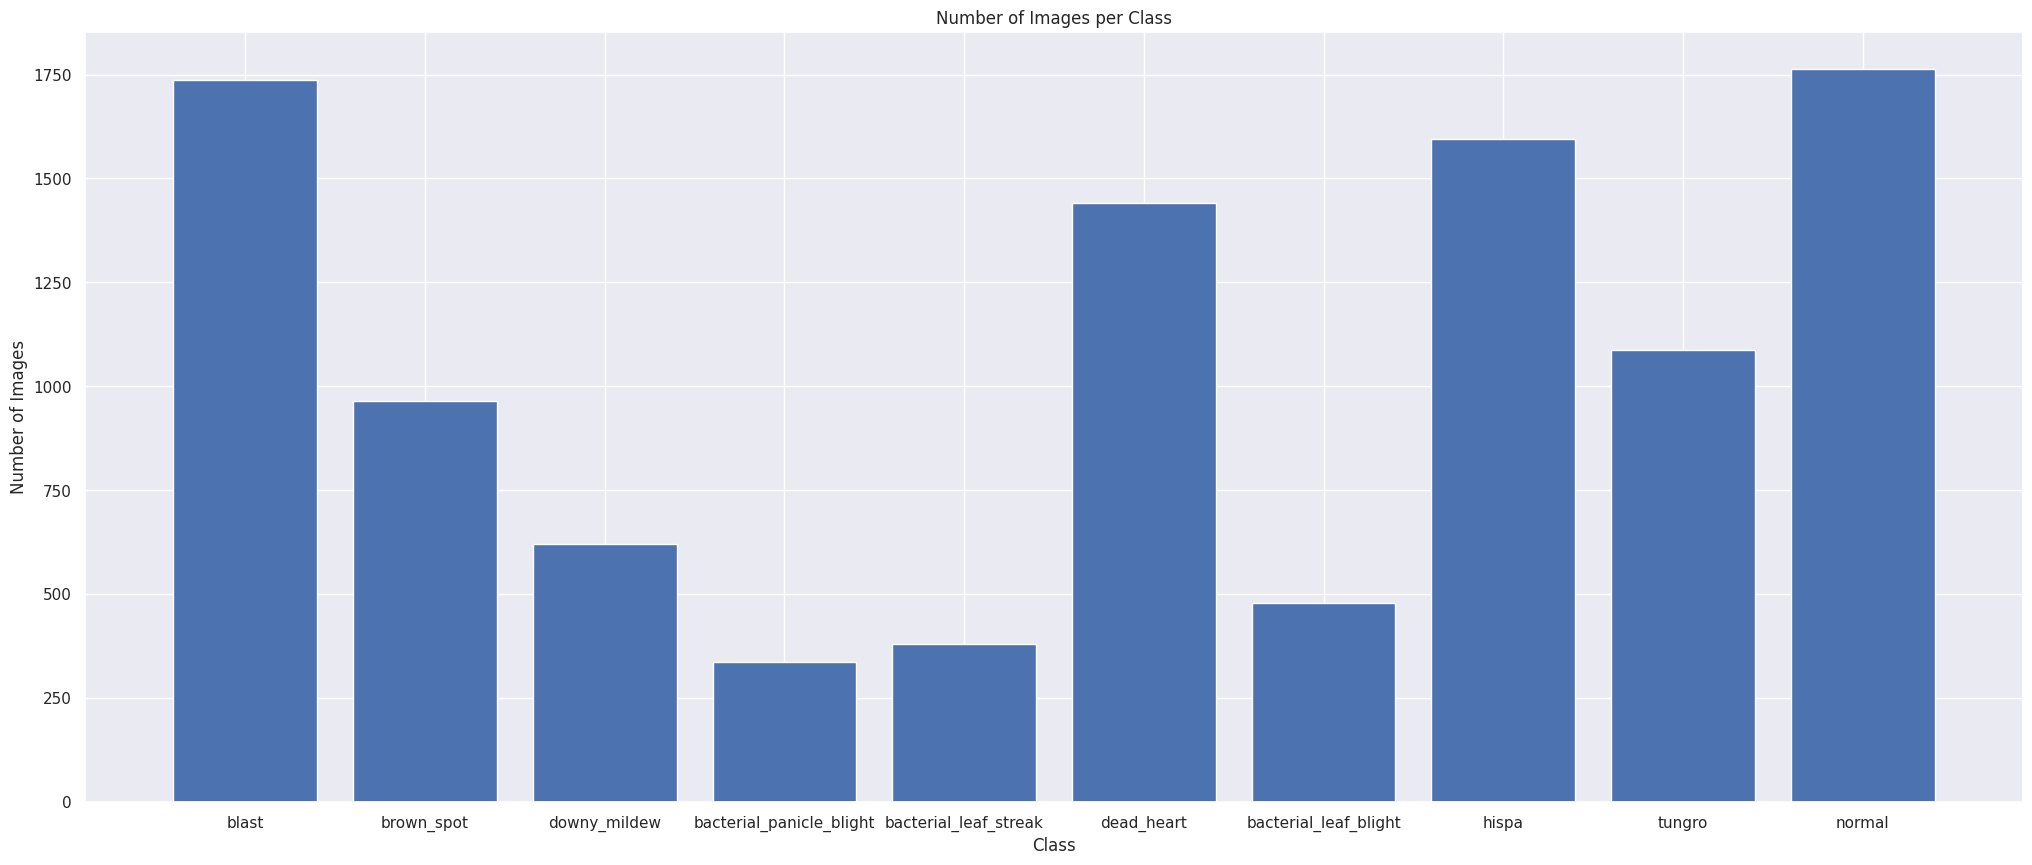

In [ ]:
sns.set()
plt.figure(figsize=(25, 10))
plt.bar(x=trainImageCount.keys(), height=trainImageCount.values())
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.show()

In [ ]:
def printImages(trainFolders, ncol, nrow):
  for trainFolder in trainFolders:
    images=random.choices(glob(os.path.join(trainFolder, '*')), k=(ncol*nrow))
    plt.figure(figsize = (16, 16))
    for index, image in enumerate(images):
      image=plt.imread(image)
      plt.subplot(ncol, nrow, index+1)
      plt.xlabel(os.path.basename(os.path.basename(trainFolder)))
      plt.imshow(image)

In [ ]:
printImages(trainFolders=trainFolders, ncol=3, nrow=3)

In [ ]:
def getImageSize(trainFolders):
  imageSize=set()
  for trainFolder in trainFolders:
    images=glob(os.path.join(trainFolder, '*'))
    for image in images:
      image=cv.imread(image)
      imageSize.add(image.shape)
  return imageSize



imageSize=getImageSize(trainFolders)
print(f'Image size: {imageSize}')


Image size: {(640, 480, 3), (480, 640, 3)}


In [ ]:
targetSize = [224, 224]
inputSize = targetSize + [3]
batchSize = 32
rescale = 1./ 255
epochs = 100


dataGen = ImageDataGenerator(rescale=rescale,
                              horizontal_flip = True,
                              vertical_flip = True,
                              shear_range=16,
                              validation_split =0.2)


trainGenerator = dataGen.flow_from_directory(trainDir,
                                              target_size=targetSize,
                                              class_mode='categorical',
                                              batch_size = batchSize,
                                              shuffle = True,
                                              subset = 'training')

validGenerator = dataGen.flow_from_directory(trainDir,
                                              target_size=targetSize,
                                              class_mode='categorical',
                                              batch_size = batchSize,
                                              shuffle = True,
                                              subset = 'validation')

Found 8330 images belonging to 10 classes.
Found 2077 images belonging to 10 classes.


In [ ]:
stepsPerTrainingEpoch=trainGenerator.n // trainGenerator.batch_size
stepsPerValidationEpoch=validGenerator.n // validGenerator.batch_size

print(f"Every training epoch has {stepsPerTrainingEpoch} steps.")
print(f"Every validating epoch has {stepsPerValidationEpoch} steps.")

Every training epoch has 260 steps.
Every validating epoch has 64 steps.


In [ ]:
classIndices=trainGenerator.class_indices
outputLabels={ index : label for label, index in classIndices.items()}


print(f"Class Indices : {classIndices}")
print(f"Output Labels : {outputLabels}")

Class Indices : {'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}
Output Labels : {0: 'bacterial_leaf_blight', 1: 'bacterial_leaf_streak', 2: 'bacterial_panicle_blight', 3: 'blast', 4: 'brown_spot', 5: 'dead_heart', 6: 'downy_mildew', 7: 'hispa', 8: 'normal', 9: 'tungro'}


In [ ]:
y = trainGenerator.classes

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 2.1692708333333335, 1: 2.7401315789473686, 2: 3.085185185185185, 3: 0.5988497483824586, 4: 1.0790155440414508, 5: 0.7218370883882149, 6: 1.6794354838709677, 7: 0.6528213166144201, 8: 0.589943342776204, 9: 0.9563719862227325}


In [ ]:
earlyStopping = EarlyStopping(monitor='val_loss',
                              patience=15,
                              verbose=1)

reduceLr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=5,
                              min_lr=0.000001,
                              model='auto')

modelCheck = ModelCheckpoint("model_weights.h5",
                             monitor="val_accuracy",
                             save_weights_only=True,
                             mode="max",
                             verbose=1)


callBacks = [earlyStopping, reduceLr, modelCheck, PlotLossesKerasTF()]

In [ ]:
denseNet=DenseNet201(weights='imagenet', include_top=False, input_shape=inputSize)

74836368/74836368 [==============================] - 0s 0us/step


In [ ]:
for layer in denseNet.layers:
  layer.trainable=False

In [ ]:
x=denseNet.output
x=Flatten()(x)
x=Dense(outputSize, activation='softmax')(x)

In [ ]:
model=Model(inputs=denseNet.input, outputs=x)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

In [ ]:
visualkeras.layered_view(model, legend =True)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

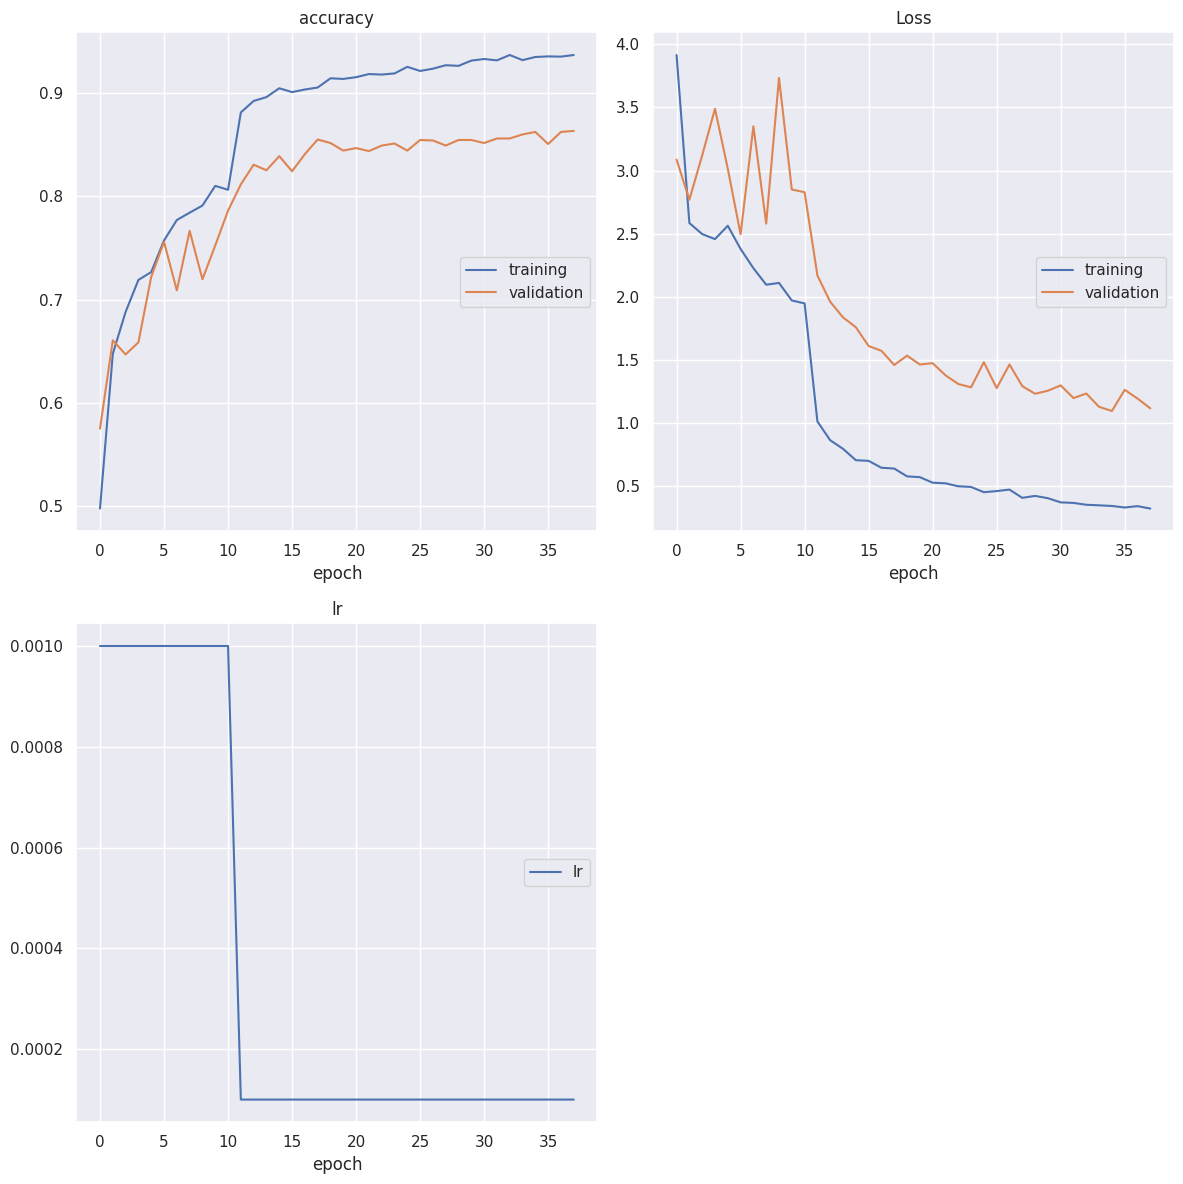

accuracy
	training         	 (min:    0.498, max:    0.937, cur:    0.937)
	validation       	 (min:    0.575, max:    0.863, cur:    0.863)
Loss
	training         	 (min:    0.324, max:    3.915, cur:    0.324)
	validation       	 (min:    1.097, max:    3.734, cur:    1.118)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
260/260 [==============================] - 163s 629ms/step - loss: 0.3243 - accuracy: 0.9367 - val_loss: 1.1180 - val_accuracy: 0.8633 - lr: 1.0000e-04
Epoch 39/100
260/260 [==============================] - ETA: 0s - loss: 0.3416 - accuracy: 0.9369

In [ ]:
modelHistory = model.fit_generator(trainGenerator,
                                steps_per_epoch=stepsPerTrainingEpoch,
                                epochs = 100,
                                verbose=1,
                                callbacks=callBacks,
                                validation_data=validGenerator,
                                validation_steps=stepsPerValidationEpoch,
                                workers=-1,
                                use_multiprocessing=True,
                                shuffle=True)

In [ ]:
def plotHistory(modeHistory):
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(modeHistory.history['loss'])
  plt.plot(modeHistory.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')

  plt.subplot(1, 2, 2)
  plt.plot(modeHistory.history['accuracy'])
  plt.plot(modeHistory.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='lower right')
  plt.show()

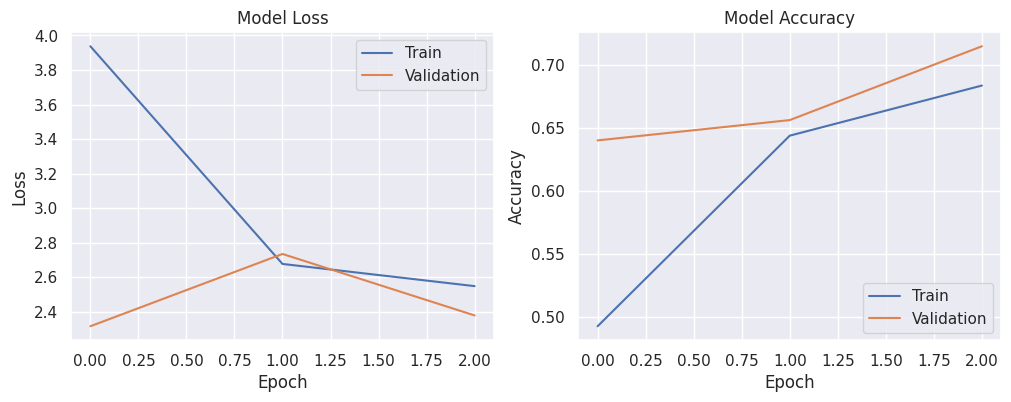

In [ ]:
plotHistory(modeHistory=modelHistory)